<a href="https://colab.research.google.com/github/Caterinasacco/Semantic-Segmentation-/blob/main/Semantic_Segmentation_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerie e modello preaddestrato ResNet-50 dilated come encoder e un PPM (Pyramid Pooling Module) come decoder


In [ ]:
!pip install torch torchvision matplotlib scipy pillow
!pip install git+https://github.com/CSAILVision/semantic-segmentation-pytorch.git


In [ ]:
import torch
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
import os
import urllib.request
import csv
import torch

In [ ]:


# Crea le cartelle
os.makedirs('ckpt/ade20k-resnet50dilated-ppm_deepsup/', exist_ok=True)

# URL dei pesi
encoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
decoder_url = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'

# Download file
urllib.request.urlretrieve(encoder_url, 'ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
urllib.request.urlretrieve(decoder_url, 'ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth')


Download completato: encoder_epoch_20.pth e decoder_epoch_20.pth


In [ ]:
# Carica i colori e i nomi delle classi
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

# Crea il modello preaddestrato
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')

net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()


Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
!wget https://raw.githubusercontent.com/CSAILVision/semantic-segmentation-pytorch/master/example_images/ADE_val_00001519.jpg -P ./data/


--2024-12-27 10:25:41--  https://raw.githubusercontent.com/CSAILVision/semantic-segmentation-pytorch/master/example_images/ADE_val_00001519.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-27 10:25:41 ERROR 404: Not Found.



#Preprocessing immagini

In [ ]:


# Trasformazioni per il preprocessing
pil_to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # Media RGB del dataset
        std=[0.229, 0.224, 0.225]    # Deviazione standard RGB
    )
])

# Carica e preprocessa l'immagine
pil_image = Image.open('/content/data/dae9cde18efb470786b6e0ba6ae4354b-1.jpg')
img_original = np.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data.unsqueeze(0).cpu()}
output_size = img_data.shape[1:]


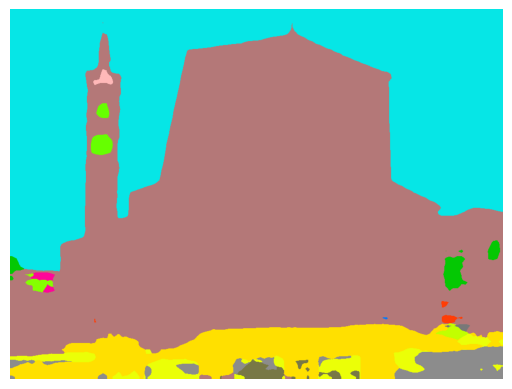

In [ ]:
#colori per la segmentazione
colors = scipy.io.loadmat('data/color150.mat')['colors']

def visualize_result(pred):
    """
    Visualizza solo la segmentazione predetta senza titoli o bordi.
    """
    pred_color = colorEncode(pred, colors).astype(np.uint8)
    plt.imshow(pred_color)
    plt.axis('off')  # Rimuove gli assi
    plt.show()

with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Ottieni la mappa delle classi predette
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(pred)


#Classe specifica

Classe visualizzata: building


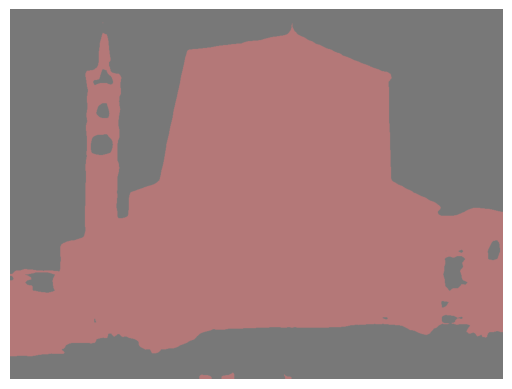

Classe visualizzata: sky


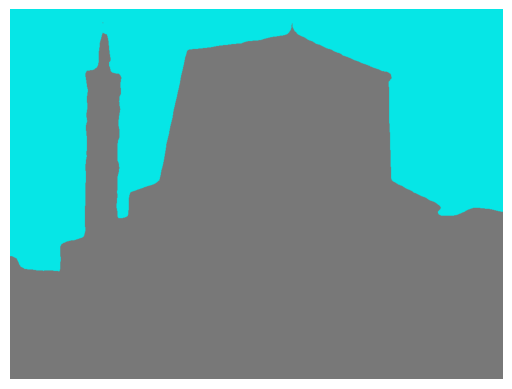

Classe visualizzata: stairs


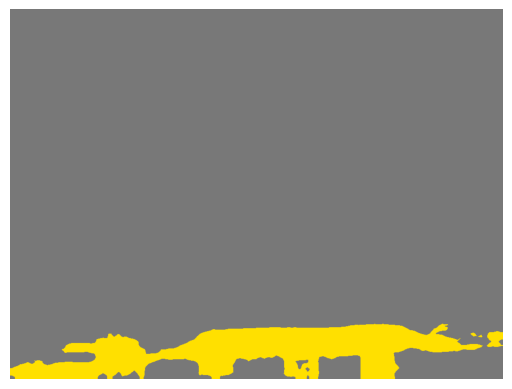

Classe visualizzata: road


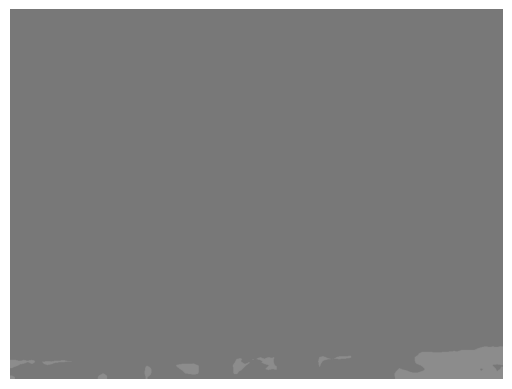

Classe visualizzata: sidewalk


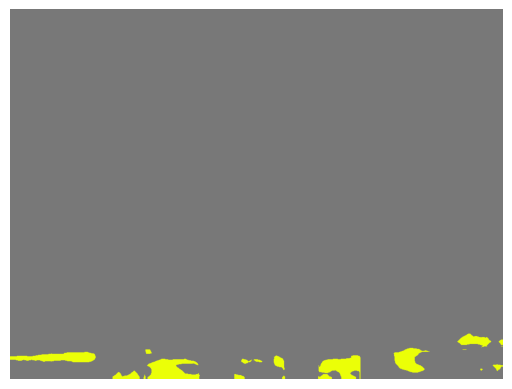

Classe visualizzata: tree


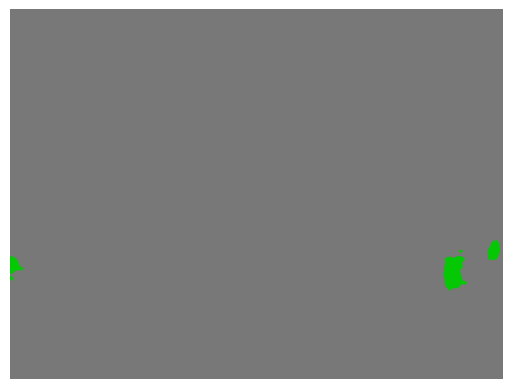

Classe visualizzata: earth


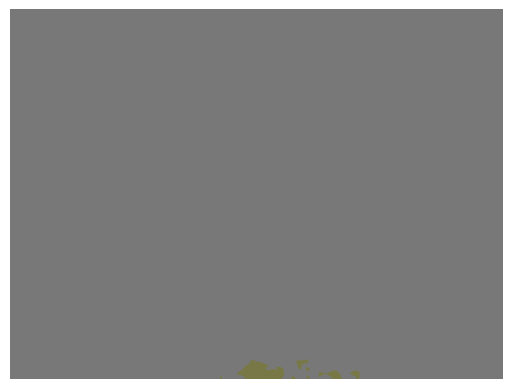

Classe visualizzata: clock


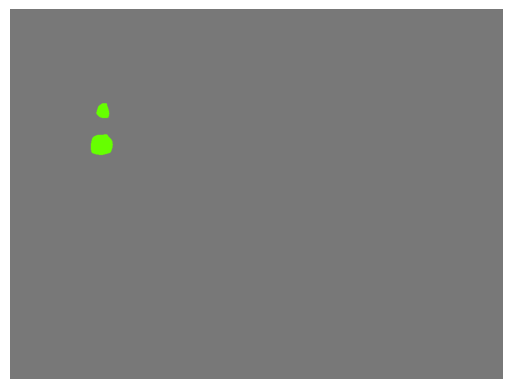

Classe visualizzata: bench


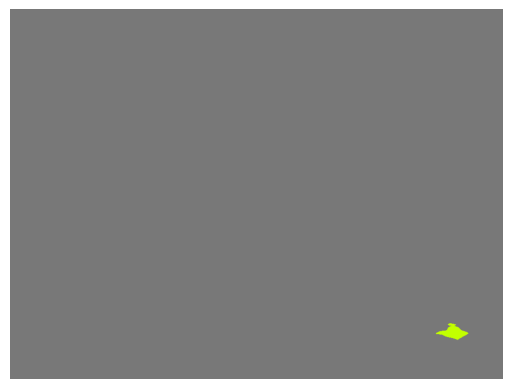

Classe visualizzata: trade


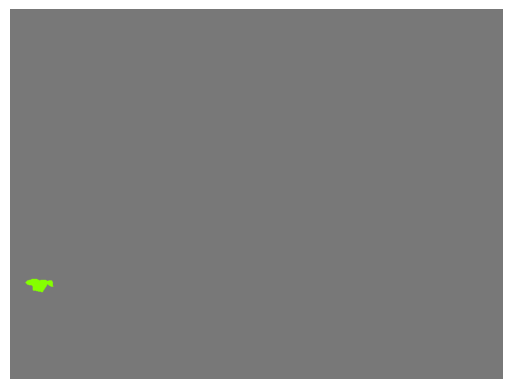

Classe visualizzata: signboard


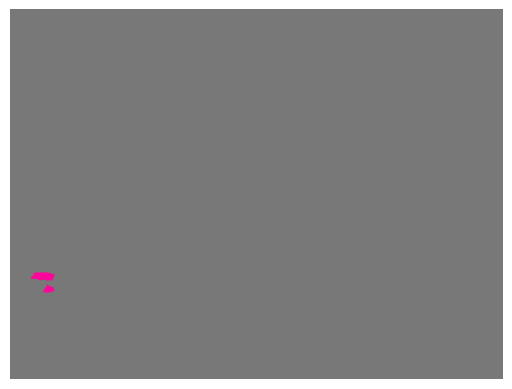

Classe visualizzata: tower


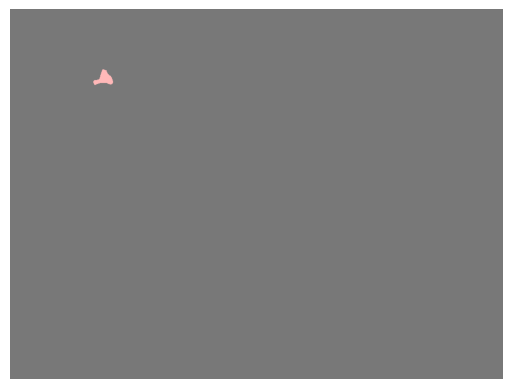

Classe visualizzata: railing


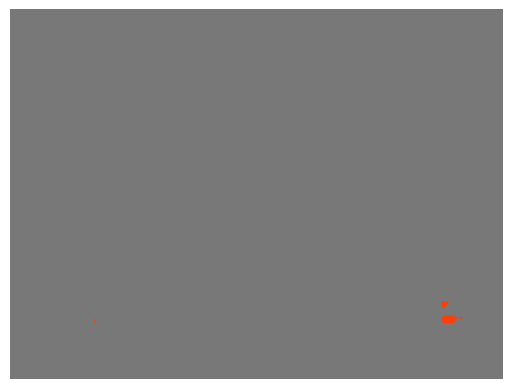

Classe visualizzata: wall


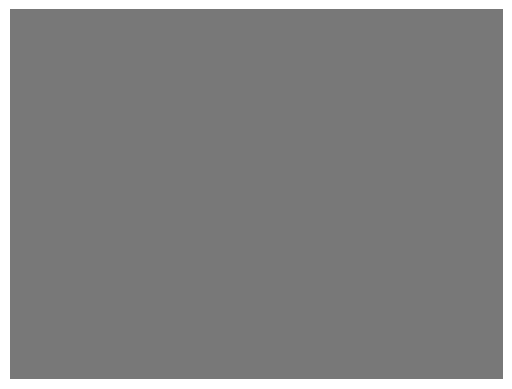

Classe visualizzata: poster


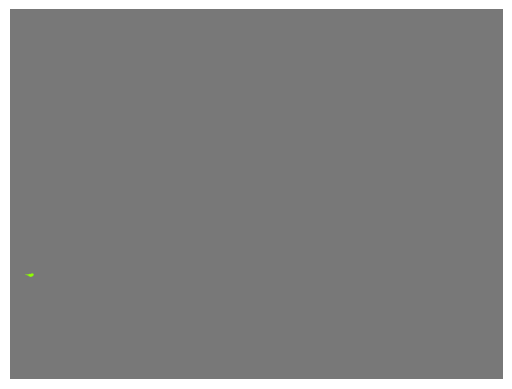

In [ ]:
def visualize_result(pred, class_index=None):
    """
    Visualizza la segmentazione predetta per una classe specifica.
    """
    if class_index is not None:
        pred_mask = np.zeros_like(pred)
        pred_mask[pred == class_index] = class_index  # Mantiene solo i pixel della classe selezionata
        pred_color = colorEncode(pred_mask, colors).astype(np.uint8)
        print(f'Classe visualizzata: {names.get(class_index + 1, "Sconosciuta")}')
    else:
        pred_color = colorEncode(pred, colors).astype(np.uint8)

    plt.imshow(pred_color)
    plt.axis('off')  # Rimuove assi
    plt.show()

with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Ottieni la mappa delle classi predette
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
predicted_classes = np.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(pred, c)
